In [2]:
import pandas as pd

In [3]:
from prophet import Prophet

In [4]:
df=pd.read_csv("final_df_binary.csv")

In [5]:
print(df.head())

         date section_id  employees_on_duty  total_task_time_minutes  \
0  2021-01-01    SEC-001                  1               834.569483   
1  2021-01-01    SEC-002                  4              1525.368990   
2  2021-01-01    SEC-003                  2               662.095279   
3  2021-01-01    SEC-004                  4              1499.112620   
4  2021-01-01    SEC-005                  3              1238.533073   

   is_holiday  is_weekend  
0           0           0  
1           0           0  
2           0           0  
3           0           0  
4           0           0  


In [6]:
print(df.tail())

             date section_id  employees_on_duty  total_task_time_minutes  \
10951  2025-12-31    SEC-002                  0                      0.0   
10952  2025-12-31    SEC-003                  0                      0.0   
10953  2025-12-31    SEC-004                  0                      0.0   
10954  2025-12-31    SEC-005                  0                      0.0   
10955  2025-12-31    SEC-006                  0                      0.0   

       is_holiday  is_weekend  
10951           0           0  
10952           0           0  
10953           0           0  
10954           0           0  
10955           0           0  


In [7]:
df['ds']=pd.to_datetime(df['date'])

In [8]:
df['y'] = df['total_task_time_minutes']
df = df.sort_values(['section_id','ds'])


In [9]:
train_df = df[(df['ds'] >= '2021-01-01') & (df['ds'] <= '2023-12-31')]

# ------------------------------
# 5. Select future data to predict 2024
# ------------------------------
# Future dataframe includes 2024 dates only
future_df = df[(df['ds'] >= '2024-01-01') & (df['ds'] <= '2024-12-31')]

In [10]:

# ------------------------------
# 6. Prophet modeling per section
# ------------------------------
sections = df['section_id'].unique()
predictions_2024 = pd.DataFrame()

for sec in sections:
    sec_train = train_df[train_df['section_id']==sec].copy()
    sec_future = future_df[future_df['section_id']==sec].copy()
    
    # Initialize Prophet
    model = Prophet(daily_seasonality=True, yearly_seasonality=True)
    
    # Add future regressors
    model.add_regressor('is_holiday')
    model.add_regressor('is_weekend')
    
    # Fit on historical data
    model.fit(sec_train[['ds','y','is_holiday','is_weekend']])
    
    # Prepare future dataframe with known regressors
    sec_future_features = sec_future[['ds','is_holiday','is_weekend']].copy()
    
    # Predict
    forecast = model.predict(sec_future_features)
    
    # Add section_id and keep relevant columns
    forecast['section_id'] = sec
    forecast_sec = forecast[['ds','section_id','yhat','yhat_lower','yhat_upper']]
    
    # Append to predictions
    predictions_2024 = pd.concat([predictions_2024, forecast_sec], axis=0)

23:53:19 - cmdstanpy - INFO - Chain [1] start processing
23:53:20 - cmdstanpy - INFO - Chain [1] done processing
23:53:21 - cmdstanpy - INFO - Chain [1] start processing
23:53:21 - cmdstanpy - INFO - Chain [1] done processing
23:53:21 - cmdstanpy - INFO - Chain [1] start processing
23:53:21 - cmdstanpy - INFO - Chain [1] done processing
23:53:22 - cmdstanpy - INFO - Chain [1] start processing
23:53:22 - cmdstanpy - INFO - Chain [1] done processing
23:53:22 - cmdstanpy - INFO - Chain [1] start processing
23:53:22 - cmdstanpy - INFO - Chain [1] done processing
23:53:23 - cmdstanpy - INFO - Chain [1] start processing
23:53:23 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
# 7. Reset index and inspect
# ------------------------------
predictions_2024 = predictions_2024.sort_values(['section_id','ds']).reset_index(drop=True)
print(predictions_2024.head(20))


           ds section_id         yhat  yhat_lower   yhat_upper
0  2024-01-01    SEC-001  1120.329208  512.853782  1706.590226
1  2024-01-02    SEC-001   751.023338  123.575642  1324.353540
2  2024-01-03    SEC-001   641.033174   41.410919  1224.272273
3  2024-01-04    SEC-001   680.708876   71.007050  1280.755277
4  2024-01-05    SEC-001   783.587418  173.151228  1338.480948
5  2024-01-06    SEC-001  -147.968677 -746.000027   466.967665
6  2024-01-07    SEC-001  -150.514604 -804.148671   411.624440
7  2024-01-08    SEC-001  1099.164988  546.526393  1656.985134
8  2024-01-09    SEC-001   730.964141  162.857863  1326.482842
9  2024-01-10    SEC-001   622.056774   40.120528  1234.218923
10 2024-01-11    SEC-001   662.802588   96.655875  1244.968645
11 2024-01-12    SEC-001   766.750156  179.748156  1391.050617
12 2024-01-13    SEC-001  -163.724809 -733.878239   377.438591
13 2024-01-14    SEC-001  -165.163224 -756.214413   445.002934
14 2024-01-15    SEC-001   366.825909 -199.256843   979

In [12]:
# 8. Compare predictions with actual 2024 total_task_time_minutes
# ------------------------------
actual_2024 = df[(df['ds'] >= '2024-01-01') & (df['ds'] <= '2024-12-31')]
comparison = pd.merge(actual_2024, predictions_2024, on=['ds','section_id'])
comparison['error'] = comparison['y'] - comparison['yhat']
comparison['abs_error'] = comparison['error'].abs()
comparison['pct_error'] = comparison['abs_error'] / comparison['y'] * 100

print(comparison.head(20))
print("Mean Absolute Error (MAE):", comparison['abs_error'].mean())
print("Mean Absolute Percentage Error (MAPE):", comparison['pct_error'].mean())

# ------------------------------
# Notes:
# 1. This lets you see how well the model would have predicted 2024
# 2. is_holiday and is_weekend are used as known future regressors
# 3. error metrics (MAE, MAPE) give you performance evaluation

          date section_id  employees_on_duty  total_task_time_minutes  \
0   2024-01-01    SEC-001                  2               728.137059   
1   2024-01-02    SEC-001                  2               552.800915   
2   2024-01-03    SEC-001                  2               552.353007   
3   2024-01-04    SEC-001                  2               613.022282   
4   2024-01-05    SEC-001                  3               904.401298   
5   2024-01-06    SEC-001                  0                 0.000000   
6   2024-01-07    SEC-001                  0                 0.000000   
7   2024-01-08    SEC-001                  2               825.477360   
8   2024-01-09    SEC-001                  3               957.468202   
9   2024-01-10    SEC-001                  2               451.373651   
10  2024-01-11    SEC-001                  1               340.745409   
11  2024-01-12    SEC-001                  3               902.009581   
12  2024-01-13    SEC-001                  0       

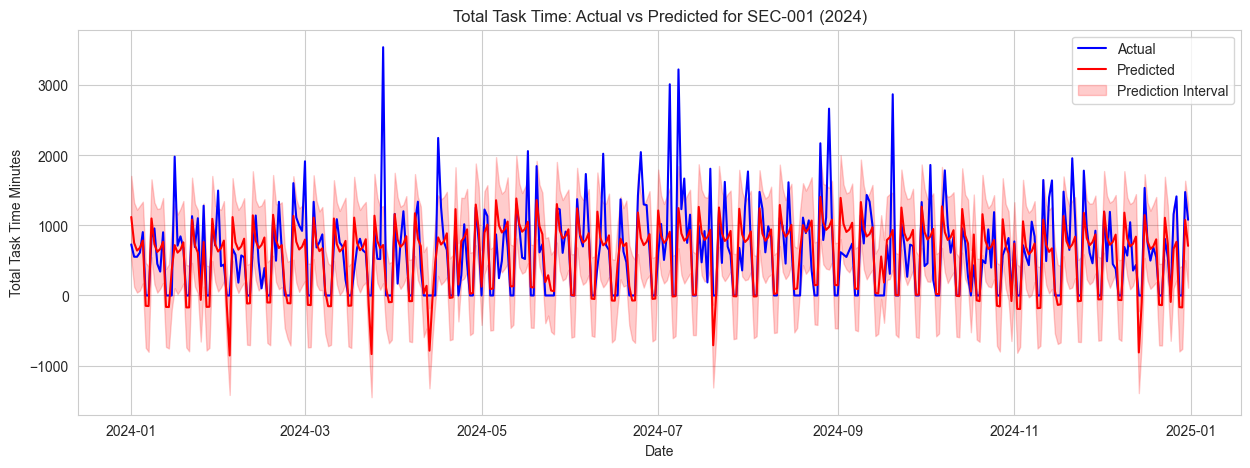

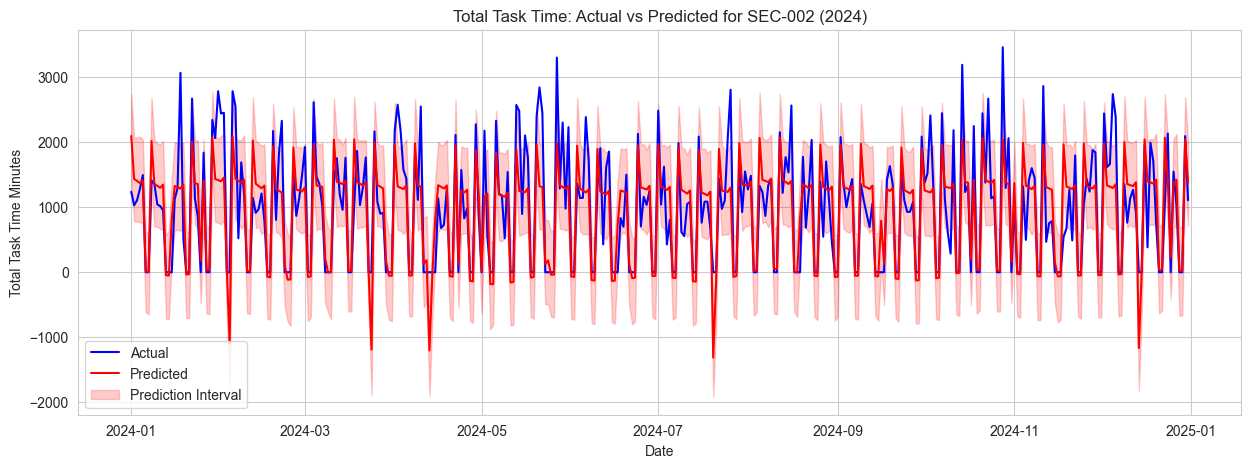

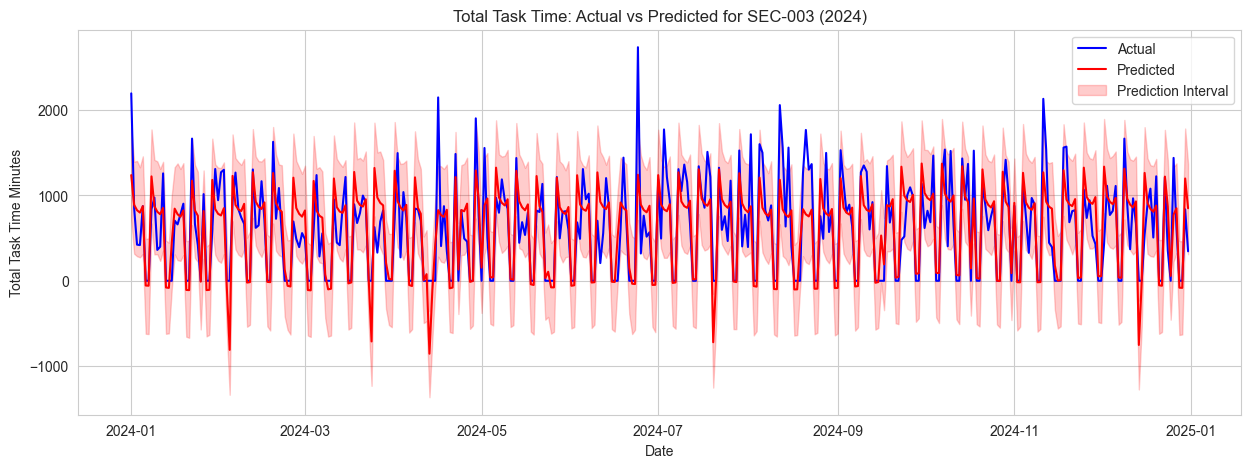

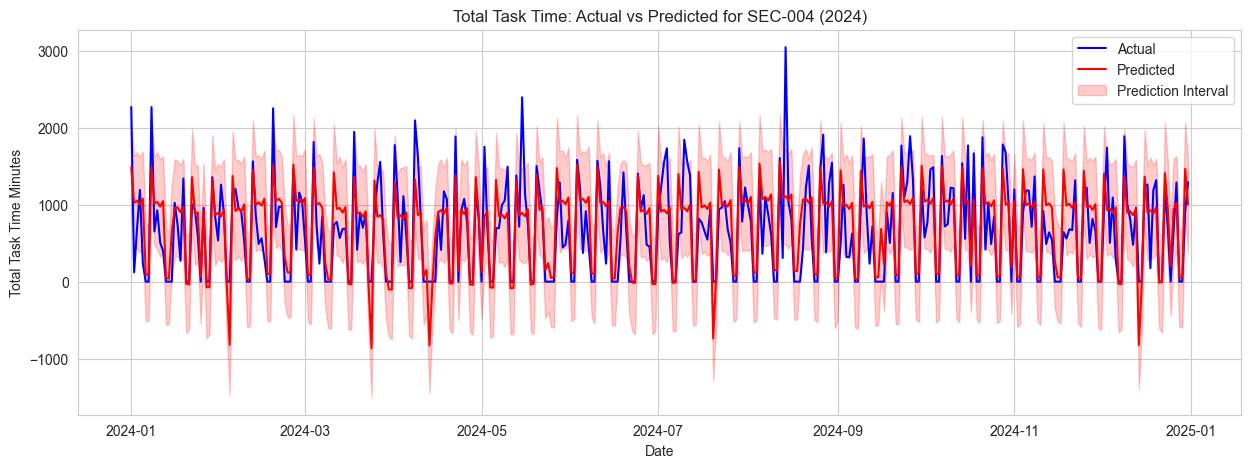

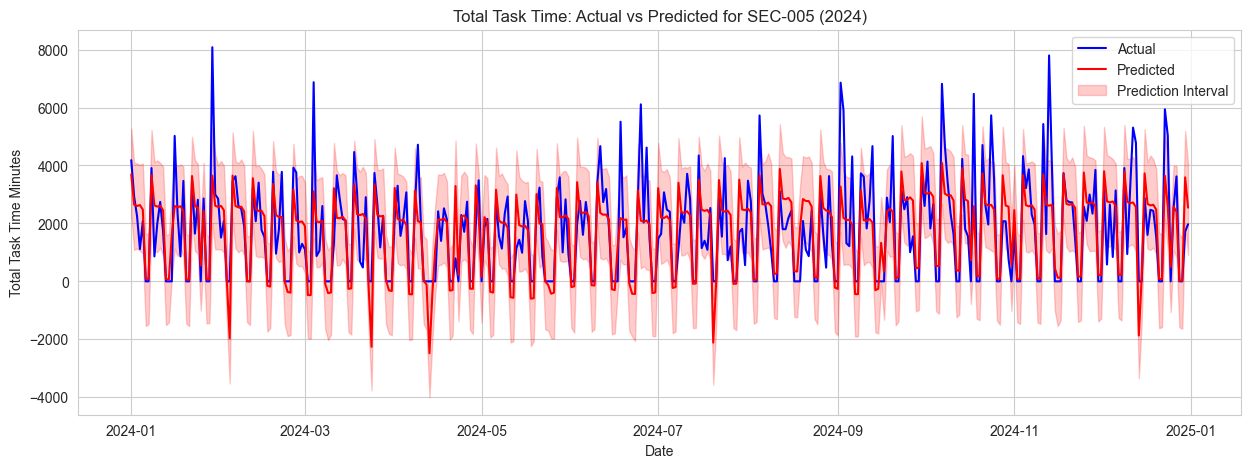

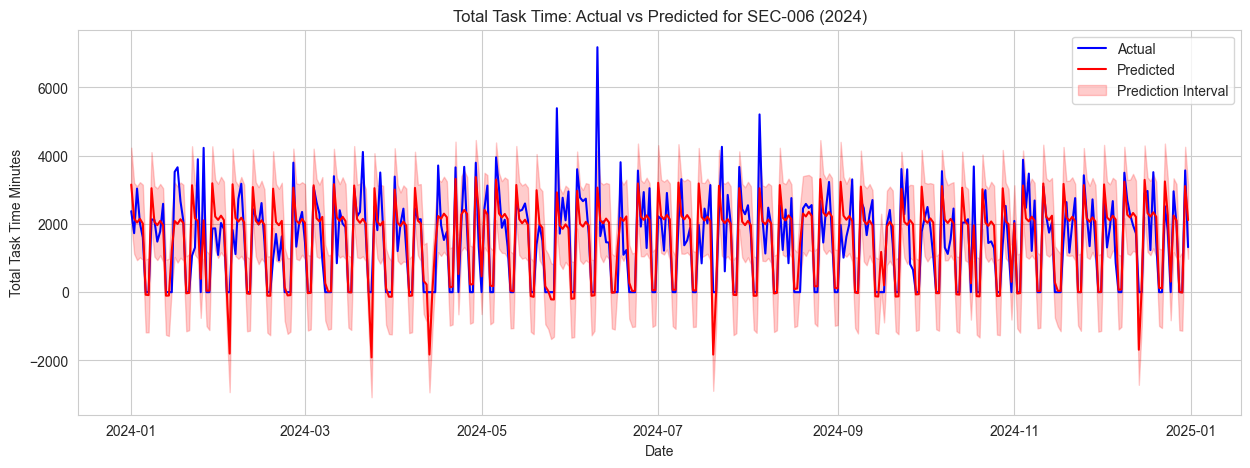

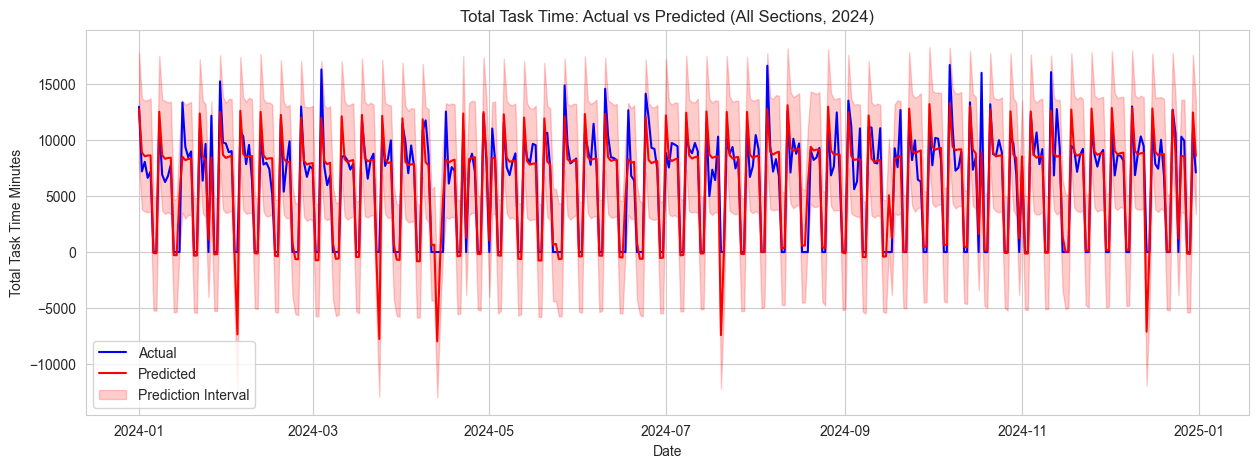

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set_style("whitegrid")

# ------------------------------
# 1. Plot actual vs predicted for each section
# ------------------------------
sections = comparison['section_id'].unique()
for sec in sections:
    sec_df = comparison[comparison['section_id']==sec].copy()
    
    plt.figure(figsize=(15,5))
    plt.plot(sec_df['ds'], sec_df['y'], label='Actual', color='blue')
    plt.plot(sec_df['ds'], sec_df['yhat'], label='Predicted', color='red')
    plt.fill_between(sec_df['ds'], sec_df['yhat_lower'], sec_df['yhat_upper'],
                     color='red', alpha=0.2, label='Prediction Interval')
    plt.title(f"Total Task Time: Actual vs Predicted for {sec} (2024)")
    plt.xlabel("Date")
    plt.ylabel("Total Task Time Minutes")
    plt.legend()
    plt.show()

# ------------------------------
# 2. Plot overall total task time across all sections
# ------------------------------
overall_df = comparison.groupby('ds')[['y','yhat','yhat_lower','yhat_upper']].sum().reset_index()

plt.figure(figsize=(15,5))
plt.plot(overall_df['ds'], overall_df['y'], label='Actual', color='blue')
plt.plot(overall_df['ds'], overall_df['yhat'], label='Predicted', color='red')
plt.fill_between(overall_df['ds'], overall_df['yhat_lower'], overall_df['yhat_upper'],
                 color='red', alpha=0.2, label='Prediction Interval')
plt.title("Total Task Time: Actual vs Predicted (All Sections, 2024)")
plt.xlabel("Date")
plt.ylabel("Total Task Time Minutes")
plt.legend()
plt.show()


In [14]:
# ------------------------------
# 1. Columns to keep
# ------------------------------
cols = ['ds', 'is_holiday', 'is_weekend', 'y', 'yhat']
comparison['error'] = comparison['y'] - comparison['yhat']

# ------------------------------
# 2. Generate and display tables per section
# ------------------------------
sections = comparison['section_id'].unique()

section_tables = {}  # store each section's table in a dictionary

for sec in sections:
    sec_df = comparison[comparison['section_id']==sec].copy()
    sec_table = sec_df[cols + ['error']].reset_index(drop=True)
    section_tables[sec] = sec_table
    print(f"\nSection: {sec}")
    print(sec_table.head(10))  # print first 10 rows for preview



Section: SEC-001
          ds  is_holiday  is_weekend           y         yhat       error
0 2024-01-01           0           0  728.137059  1120.329208 -392.192150
1 2024-01-02           0           0  552.800915   751.023338 -198.222422
2 2024-01-03           0           0  552.353007   641.033174  -88.680167
3 2024-01-04           0           0  613.022282   680.708876  -67.686594
4 2024-01-05           0           0  904.401298   783.587418  120.813880
5 2024-01-06           0           1    0.000000  -147.968677  147.968677
6 2024-01-07           0           1    0.000000  -150.514604  150.514604
7 2024-01-08           0           0  825.477360  1099.164988 -273.687628
8 2024-01-09           0           0  957.468202   730.964141  226.504061
9 2024-01-10           0           0  451.373651   622.056774 -170.683123

Section: SEC-002
          ds  is_holiday  is_weekend            y         yhat       error
0 2024-01-01           0           0  1238.058059  2096.566212 -858.508153


In [15]:
import numpy as np

# ------------------------------
# 1. Add error columns
# ------------------------------
comparison['error'] = comparison['y'] - comparison['yhat']
comparison['abs_error'] = comparison['error'].abs()
comparison['pct_error'] = comparison['abs_error'] / comparison['y'] * 100

# ------------------------------
# 2. Initialize dictionary to store section-wise metrics
# ------------------------------
section_errors = {}

sections = comparison['section_id'].unique()

for sec in sections:
    sec_df = comparison[comparison['section_id']==sec]
    
    mae = sec_df['abs_error'].mean()
    mape = sec_df['pct_error'].mean()
    rmse = np.sqrt((sec_df['error']**2).mean())
    
    section_errors[sec] = {
        'MAE': mae,
        'MAPE (%)': mape,
        'RMSE': rmse
    }

# ------------------------------
# 3. Display section-wise error metrics
# ------------------------------
import pprint
pprint.pprint(section_errors)

# ------------------------------
# 4. Optional: Keep daily error table per section
# ------------------------------
section_daily_errors = {}
for sec in sections:
    sec_df = comparison[comparison['section_id']==sec].copy()
    daily_table = sec_df[['ds','is_holiday','is_weekend','y','yhat','error','abs_error','pct_error']]
    section_daily_errors[sec] = daily_table
    print(f"\nDaily errors for section {sec}:")
    print(daily_table.head(10))  # preview first 10 rows


{'SEC-001': {'MAE': np.float64(290.9913406078424),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(446.24670192558466)},
 'SEC-002': {'MAE': np.float64(360.4010140316233),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(511.88616429918295)},
 'SEC-003': {'MAE': np.float64(242.9369910162849),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(341.9179317490985)},
 'SEC-004': {'MAE': np.float64(286.26310102050127),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(393.2073409316392)},
 'SEC-005': {'MAE': np.float64(778.2253840327322),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(1124.9418316623858)},
 'SEC-006': {'MAE': np.float64(510.65819871519176),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(742.4942491177947)}}

Daily errors for section SEC-001:
          ds  is_holiday  is_weekend           y         yhat       error  \
0 2024-

In [16]:
import pandas as pd
from scipy import stats

# Group by section_id for mean and median
section_stats = df.groupby('section_id')['total_task_time_minutes'].agg(
    mean='mean',
    median='median'
).reset_index()

# Calculate mode safely
modes = []
for sec in df['section_id'].unique():
    sec_data = df[df['section_id']==sec]['total_task_time_minutes']
    mode_res = stats.mode(sec_data, nan_policy='omit')  # handles NaNs
    # Check if result is scalar or array
    if hasattr(mode_res.mode, "__len__"):
        mode_val = mode_res.mode[0]  # take first mode if multiple
    else:
        mode_val = mode_res.mode
    modes.append(mode_val)

section_stats['mode'] = modes

# Display
print(section_stats)


  section_id         mean       median  mode
0    SEC-001   523.802976   324.795535   0.0
1    SEC-002   835.693978   694.430942   0.0
2    SEC-003   540.119800   374.061102   0.0
3    SEC-004   577.413062   418.834699   0.0
4    SEC-005  1508.457552  1007.175685   0.0
5    SEC-006  1296.355927  1092.806784   0.0


In [17]:
predictions_2024.tail(20)

,ds,section_id,yhat,yhat_lower,yhat_upper
2176,2024-12-12,SEC-006,2320.315193,1210.596810,3465.412268
2177,2024-12-13,SEC-006,2205.779406,1174.461476,3271.009287
2178,2024-12-14,SEC-006,-1687.111110,-2715.384782,-529.838124
2179,2024-12-15,SEC-006,145.973840,-993.733235,1237.497085
2180,2024-12-16,SEC-006,3290.526479,2203.715711,4297.501463
2181,2024-12-17,SEC-006,2316.052963,1182.492137,3363.737052
2182,2024-12-18,SEC-006,2215.977434,1080.776561,3261.434305
2183,2024-12-19,SEC-006,2338.115973,1284.096635,3453.397134
2184,2024-12-20,SEC-006,2208.170549,1043.519398,3240.674904
2185,2024-12-21,SEC-006,126.924585,-990.404087,1274.182228


In [18]:
# ------------------------------
# 1. Ensure no negative predictions
# ------------------------------
comparison['yhat'] = comparison['yhat'].apply(lambda x: max(x, 0))

# ------------------------------
# 2. Recalculate errors
# ------------------------------
comparison['error'] = comparison['y'] - comparison['yhat']
comparison['abs_error'] = comparison['error'].abs()
comparison['pct_error'] = comparison['abs_error'] / comparison['y'] * 100

# ------------------------------
# 3. Section-wise summary errors
# ------------------------------
import numpy as np
section_errors = {}
sections = comparison['section_id'].unique()

for sec in sections:
    sec_df = comparison[comparison['section_id']==sec]
    mae = sec_df['abs_error'].mean()
    mape = sec_df['pct_error'].mean()
    rmse = np.sqrt((sec_df['error']**2).mean())
    section_errors[sec] = {
        'MAE': mae,
        'MAPE (%)': mape,
        'RMSE': rmse
    }

# ------------------------------
# 4. Display updated section-wise errors
# ------------------------------
import pprint
pprint.pprint(section_errors)

# ------------------------------
# 5. Daily error table per section (optional)
# ------------------------------
section_daily_errors = {}
for sec in sections:
    sec_df = comparison[comparison['section_id']==sec].copy()
    daily_table = sec_df[['ds','is_holiday','is_weekend','y','yhat','error','abs_error','pct_error']]
    section_daily_errors[sec] = daily_table
    print(f"\nDaily errors for section {sec}:")
    print(daily_table.head(10))  # preview first 10 rows


{'SEC-001': {'MAE': np.float64(261.13071478898047),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(433.48526810453546)},
 'SEC-002': {'MAE': np.float64(328.7240399903022),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(490.88693078049596)},
 'SEC-003': {'MAE': np.float64(221.73437596403366),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(328.56720826546024)},
 'SEC-004': {'MAE': np.float64(270.755635895163),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(381.03753789052297)},
 'SEC-005': {'MAE': np.float64(703.7309204086573),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(1088.8334418211546)},
 'SEC-006': {'MAE': np.float64(473.2089727548695),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(710.5989358749862)}}

Daily errors for section SEC-001:
          ds  is_holiday  is_weekend           y         yhat       error  \
0 2024

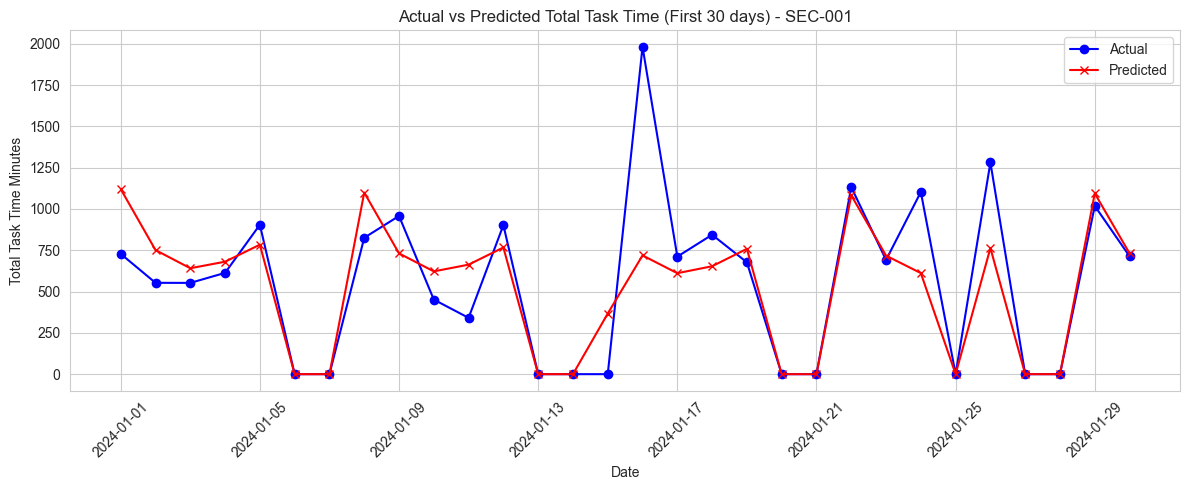

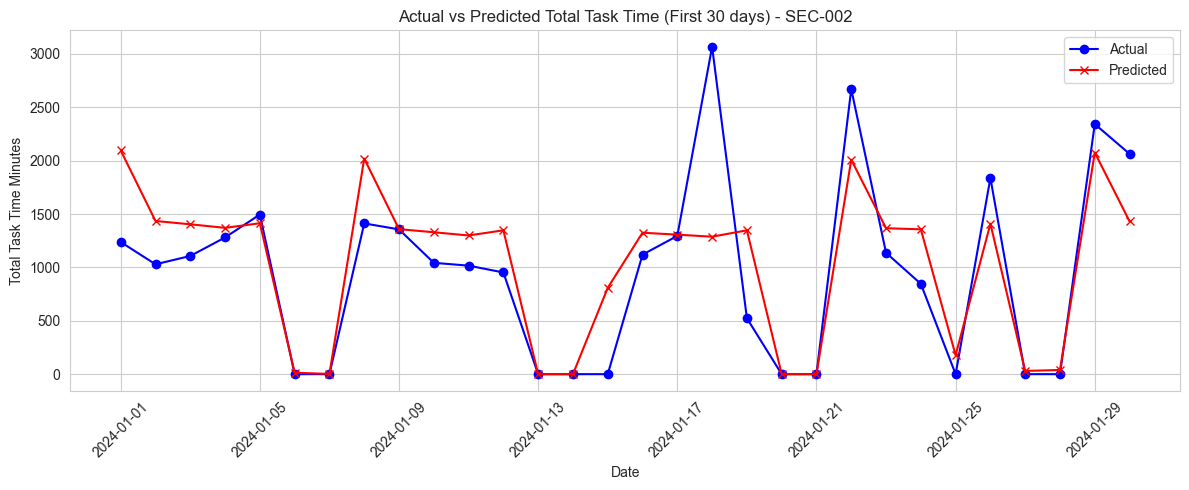

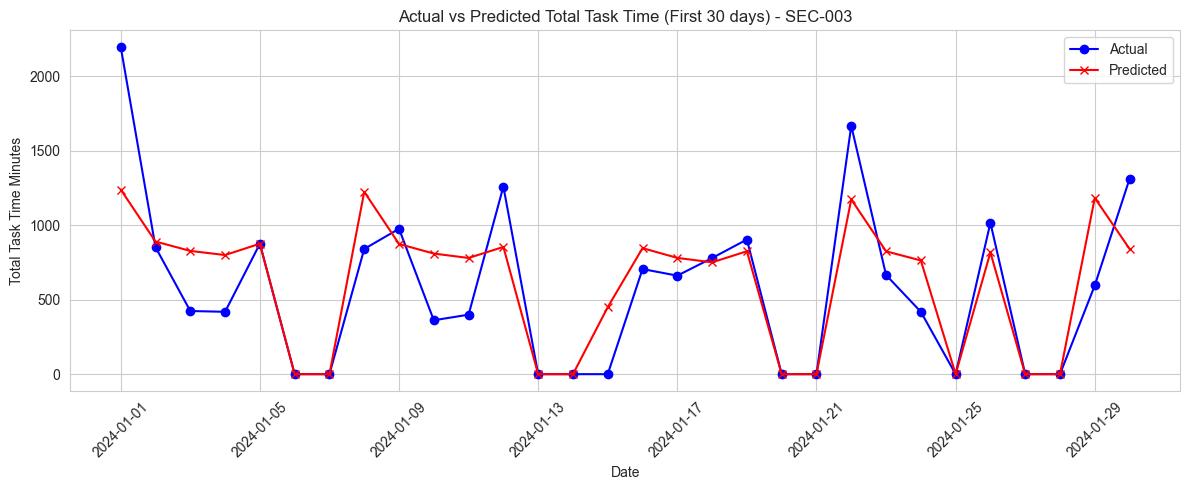

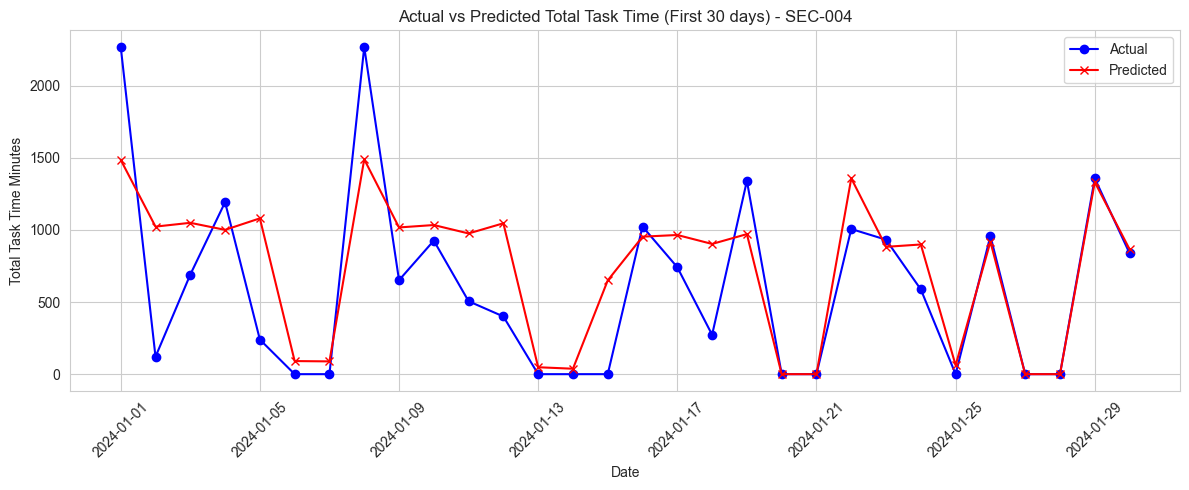

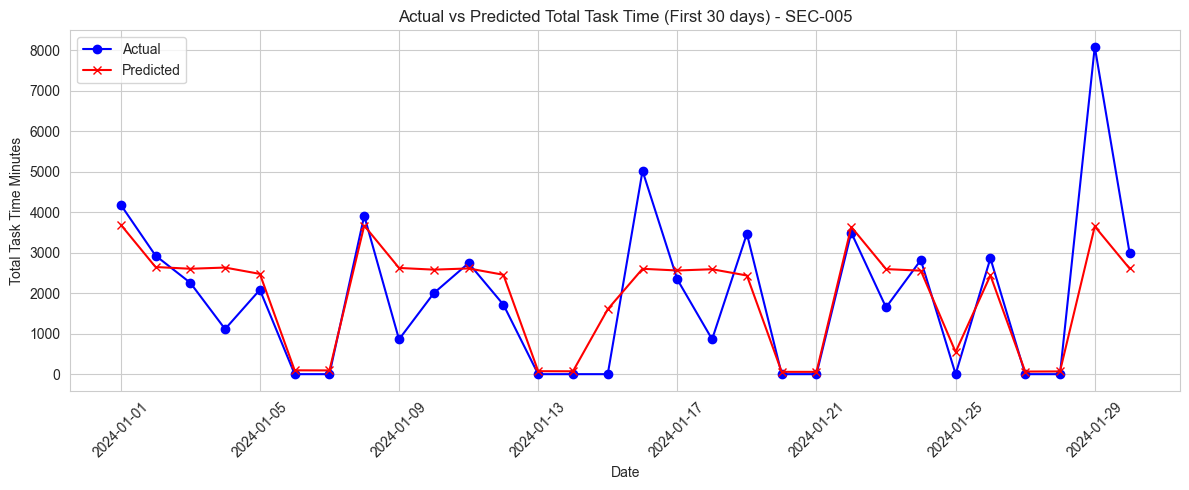

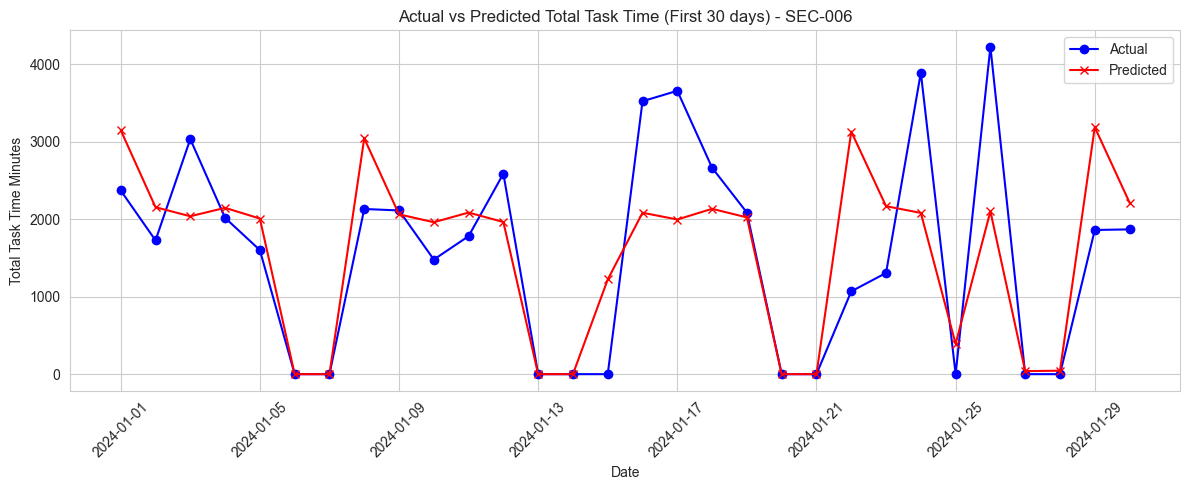

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

sections = comparison['section_id'].unique()

for sec in sections:
    sec_df = comparison[comparison['section_id']==sec].copy()
    
    # Take first 30 rows
    sec_df = sec_df.head(30)
    
    plt.figure(figsize=(12,5))
    plt.plot(sec_df['ds'], sec_df['y'], marker='o', label='Actual', color='blue')
    plt.plot(sec_df['ds'], sec_df['yhat'], marker='x', label='Predicted', color='red')
    
    plt.title(f"Actual vs Predicted Total Task Time (First 30 days) - {sec}")
    plt.xlabel("Date")
    plt.ylabel("Total Task Time Minutes")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [21]:
# ------------------------------
# 1. Ensure no negative predictions
# ------------------------------
comparison['yhat'] = comparison['yhat'].apply(lambda x: max(x, 0))

# ------------------------------
# 2. Recalculate errors
# ------------------------------
comparison['error'] = comparison['y'] - comparison['yhat']
comparison['abs_error'] = comparison['error'].abs()
comparison['pct_error'] = comparison['abs_error'] / comparison['y'] * 100

# ------------------------------
# 3. Section-wise summary errors
# ------------------------------
import numpy as np
section_errors = {}
sections = comparison['section_id'].unique()

for sec in sections:
    sec_df = comparison[comparison['section_id']==sec]
    mae = sec_df['abs_error'].mean()
    mape = sec_df['pct_error'].mean()
    rmse = np.sqrt((sec_df['error']**2).mean())
    section_errors[sec] = {
        'MAE': mae,
        'MAPE (%)': mape,
        'RMSE': rmse
    }

# ------------------------------
# 4. Display updated section-wise errors
# ------------------------------
import pprint
pprint.pprint(section_errors)

# ------------------------------
# 5. Daily error table per section (optional)
# ------------------------------
section_daily_errors = {}
for sec in sections:
    sec_df = comparison[comparison['section_id']==sec].copy()
    daily_table = sec_df[['ds','is_holiday','is_weekend','y','yhat','error','abs_error','pct_error']]
    section_daily_errors[sec] = daily_table
    print(f"\nDaily errors for section {sec}:")
    print(daily_table.head(10))  # preview first 10 rows


{'SEC-001': {'MAE': np.float64(261.13071478898047),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(433.48526810453546)},
 'SEC-002': {'MAE': np.float64(328.7240399903022),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(490.88693078049596)},
 'SEC-003': {'MAE': np.float64(221.73437596403366),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(328.56720826546024)},
 'SEC-004': {'MAE': np.float64(270.755635895163),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(381.03753789052297)},
 'SEC-005': {'MAE': np.float64(703.7309204086573),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(1088.8334418211546)},
 'SEC-006': {'MAE': np.float64(473.2089727548695),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(710.5989358749862)}}

Daily errors for section SEC-001:
          ds  is_holiday  is_weekend           y         yhat       error  \
0 2024

In [22]:
# ------------------------------
# 1. Ensure no negative predictions
# ------------------------------
comparison['yhat'] = comparison['yhat'].apply(lambda x: max(x, 0))

# ------------------------------
# 2. Recalculate errors
# ------------------------------
comparison['error'] = comparison['y'] - comparison['yhat']
comparison['abs_error'] = comparison['error'].abs()
comparison['pct_error'] = comparison['abs_error'] / comparison['y'] * 100

# ------------------------------
# 3. Section-wise summary errors
# ------------------------------
import numpy as np
section_errors = {}
sections = comparison['section_id'].unique()

for sec in sections:
    sec_df = comparison[comparison['section_id']==sec]
    mae = sec_df['abs_error'].mean()
    mape = sec_df['pct_error'].mean()
    rmse = np.sqrt((sec_df['error']**2).mean())
    section_errors[sec] = {
        'MAE': mae,
        'MAPE (%)': mape,
        'RMSE': rmse
    }

# ------------------------------
# 4. Display updated section-wise errors
# ------------------------------
import pprint
pprint.pprint(section_errors)

# ------------------------------
# 5. Daily error table per section (optional)
# ------------------------------
section_daily_errors = {}
for sec in sections:
    sec_df = comparison[comparison['section_id']==sec].copy()
    daily_table = sec_df[['ds','is_holiday','is_weekend','y','yhat','error','abs_error','pct_error']]
    section_daily_errors[sec] = daily_table
    print(f"\nDaily errors for section {sec}:")
    print(daily_table.head(10))  # preview first 10 rows


{'SEC-001': {'MAE': np.float64(261.13071478898047),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(433.48526810453546)},
 'SEC-002': {'MAE': np.float64(328.7240399903022),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(490.88693078049596)},
 'SEC-003': {'MAE': np.float64(221.73437596403366),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(328.56720826546024)},
 'SEC-004': {'MAE': np.float64(270.755635895163),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(381.03753789052297)},
 'SEC-005': {'MAE': np.float64(703.7309204086573),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(1088.8334418211546)},
 'SEC-006': {'MAE': np.float64(473.2089727548695),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(710.5989358749862)}}

Daily errors for section SEC-001:
          ds  is_holiday  is_weekend           y         yhat       error  \
0 2024

In [23]:
# ------------------------------
# 1. Ensure no negative predictions
# ------------------------------
comparison['yhat'] = comparison['yhat'].apply(lambda x: max(x, 0))

# ------------------------------
# 2. Recalculate errors
# ------------------------------
comparison['error'] = comparison['y'] - comparison['yhat']
comparison['abs_error'] = comparison['error'].abs()
comparison['pct_error'] = comparison['abs_error'] / comparison['y'] * 100

# ------------------------------
# 3. Section-wise summary errors
# ------------------------------
import numpy as np
section_errors = {}
sections = comparison['section_id'].unique()

for sec in sections:
    sec_df = comparison[comparison['section_id']==sec]
    mae = sec_df['abs_error'].mean()
    mape = sec_df['pct_error'].mean()
    rmse = np.sqrt((sec_df['error']**2).mean())
    section_errors[sec] = {
        'MAE': mae,
        'MAPE (%)': mape,
        'RMSE': rmse
    }

# ------------------------------
# 4. Display updated section-wise errors
# ------------------------------
import pprint
pprint.pprint(section_errors)

# ------------------------------
# 5. Daily error table per section (optional)
# ------------------------------
section_daily_errors = {}
for sec in sections:
    sec_df = comparison[comparison['section_id']==sec].copy()
    daily_table = sec_df[['ds','is_holiday','is_weekend','y','yhat','error','abs_error','pct_error']]
    section_daily_errors[sec] = daily_table
    print(f"\nDaily errors for section {sec}:")
    print(daily_table.head(10))  # preview first 10 rows


{'SEC-001': {'MAE': np.float64(261.13071478898047),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(433.48526810453546)},
 'SEC-002': {'MAE': np.float64(328.7240399903022),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(490.88693078049596)},
 'SEC-003': {'MAE': np.float64(221.73437596403366),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(328.56720826546024)},
 'SEC-004': {'MAE': np.float64(270.755635895163),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(381.03753789052297)},
 'SEC-005': {'MAE': np.float64(703.7309204086573),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(1088.8334418211546)},
 'SEC-006': {'MAE': np.float64(473.2089727548695),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(710.5989358749862)}}

Daily errors for section SEC-001:
          ds  is_holiday  is_weekend           y         yhat       error  \
0 2024

In [24]:
# ------------------------------
# 1. Ensure no negative predictions
# ------------------------------
comparison['yhat'] = comparison['yhat'].apply(lambda x: max(x, 0))

# ------------------------------
# 2. Recalculate errors
# ------------------------------
comparison['error'] = comparison['y'] - comparison['yhat']
comparison['abs_error'] = comparison['error'].abs()
comparison['pct_error'] = comparison['abs_error'] / comparison['y'] * 100

# ------------------------------
# 3. Section-wise summary errors
# ------------------------------
import numpy as np
section_errors = {}
sections = comparison['section_id'].unique()

for sec in sections:
    sec_df = comparison[comparison['section_id']==sec]
    mae = sec_df['abs_error'].mean()
    mape = sec_df['pct_error'].mean()
    rmse = np.sqrt((sec_df['error']**2).mean())
    section_errors[sec] = {
        'MAE': mae,
        'MAPE (%)': mape,
        'RMSE': rmse
    }

# ------------------------------
# 4. Display updated section-wise errors
# ------------------------------
import pprint
pprint.pprint(section_errors)

# ------------------------------
# 5. Daily error table per section (optional)
# ------------------------------
section_daily_errors = {}
for sec in sections:
    sec_df = comparison[comparison['section_id']==sec].copy()
    daily_table = sec_df[['ds','is_holiday','is_weekend','y','yhat','error','abs_error','pct_error']]
    section_daily_errors[sec] = daily_table
    print(f"\nDaily errors for section {sec}:")
    print(daily_table.head(10))  # preview first 10 rows


{'SEC-001': {'MAE': np.float64(261.13071478898047),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(433.48526810453546)},
 'SEC-002': {'MAE': np.float64(328.7240399903022),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(490.88693078049596)},
 'SEC-003': {'MAE': np.float64(221.73437596403366),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(328.56720826546024)},
 'SEC-004': {'MAE': np.float64(270.755635895163),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(381.03753789052297)},
 'SEC-005': {'MAE': np.float64(703.7309204086573),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(1088.8334418211546)},
 'SEC-006': {'MAE': np.float64(473.2089727548695),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(710.5989358749862)}}

Daily errors for section SEC-001:
          ds  is_holiday  is_weekend           y         yhat       error  \
0 2024

In [25]:
# ------------------------------
# 1. Ensure no negative predictions
# ------------------------------
comparison['yhat'] = comparison['yhat'].apply(lambda x: max(x, 0))

# ------------------------------
# 2. Recalculate errors
# ------------------------------
comparison['error'] = comparison['y'] - comparison['yhat']
comparison['abs_error'] = comparison['error'].abs()
comparison['pct_error'] = comparison['abs_error'] / comparison['y'] * 100

# ------------------------------
# 3. Section-wise summary errors
# ------------------------------
import numpy as np
section_errors = {}
sections = comparison['section_id'].unique()

for sec in sections:
    sec_df = comparison[comparison['section_id']==sec]
    mae = sec_df['abs_error'].mean()
    mape = sec_df['pct_error'].mean()
    rmse = np.sqrt((sec_df['error']**2).mean())
    section_errors[sec] = {
        'MAE': mae,
        'MAPE (%)': mape,
        'RMSE': rmse
    }

# ------------------------------
# 4. Display updated section-wise errors
# ------------------------------
import pprint
pprint.pprint(section_errors)

# ------------------------------
# 5. Daily error table per section (optional)
# ------------------------------
section_daily_errors = {}
for sec in sections:
    sec_df = comparison[comparison['section_id']==sec].copy()
    daily_table = sec_df[['ds','is_holiday','is_weekend','y','yhat','error','abs_error','pct_error']]
    section_daily_errors[sec] = daily_table
    print(f"\nDaily errors for section {sec}:")
    print(daily_table.head(10))  # preview first 10 rows


{'SEC-001': {'MAE': np.float64(261.13071478898047),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(433.48526810453546)},
 'SEC-002': {'MAE': np.float64(328.7240399903022),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(490.88693078049596)},
 'SEC-003': {'MAE': np.float64(221.73437596403366),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(328.56720826546024)},
 'SEC-004': {'MAE': np.float64(270.755635895163),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(381.03753789052297)},
 'SEC-005': {'MAE': np.float64(703.7309204086573),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(1088.8334418211546)},
 'SEC-006': {'MAE': np.float64(473.2089727548695),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(710.5989358749862)}}

Daily errors for section SEC-001:
          ds  is_holiday  is_weekend           y         yhat       error  \
0 2024

In [28]:
from sklearn.metrics import r2_score

# ✅ Adapted for Prophet model evaluation
# comparison dataframe has: section_id, y (actual), yhat (predicted)

section_r2_scores = {}

for section, group in comparison.groupby("section_id"):
    r2 = r2_score(group["y"], group["yhat"])
    section_r2_scores[section] = r2

# Print results
print("R² Scores by Section:")
print("-" * 30)
for section, score in section_r2_scores.items():
    print(f"Section {section}: R² = {score:.4f}")

# Overall R² score across all sections
overall_r2 = r2_score(comparison["y"], comparison["yhat"])
print("-" * 30)
print(f"Overall R² Score: {overall_r2:.4f}")

# Optional: Create a summary dataframe
r2_summary = pd.DataFrame(list(section_r2_scores.items()), 
                         columns=['section_id', 'r2_score'])
r2_summary = r2_summary.sort_values('r2_score', ascending=False)
print("\nR² Scores Summary (sorted by performance):")
print(r2_summary)

R² Scores by Section:
------------------------------
Section SEC-001: R² = 0.5089
Section SEC-002: R² = 0.6840
Section SEC-003: R² = 0.6494
Section SEC-004: R² = 0.6143
Section SEC-005: R² = 0.5852
Section SEC-006: R² = 0.7010
------------------------------
Overall R² Score: 0.6880

R² Scores Summary (sorted by performance):
  section_id  r2_score
5    SEC-006  0.701010
1    SEC-002  0.684045
2    SEC-003  0.649350
3    SEC-004  0.614340
4    SEC-005  0.585170
0    SEC-001  0.508892


In [ ]:
# ------------------------------
# 1. Ensure no negative predictions
# ------------------------------
comparison['yhat'] = comparison['yhat'].apply(lambda x: max(x, 0))

# ------------------------------
# 2. Recalculate errors
# ------------------------------
comparison['error'] = comparison['y'] - comparison['yhat']
comparison['abs_error'] = comparison['error'].abs()
comparison['pct_error'] = comparison['abs_error'] / comparison['y'] * 100

# ------------------------------
# 3. Section-wise summary errors
# ------------------------------
import numpy as np
section_errors = {}
sections = comparison['section_id'].unique()

for sec in sections:
    sec_df = comparison[comparison['section_id']==sec]
    mae = sec_df['abs_error'].mean()
    mape = sec_df['pct_error'].mean()
    rmse = np.sqrt((sec_df['error']**2).mean())
    section_errors[sec] = {
        'MAE': mae,
        'MAPE (%)': mape,
        'RMSE': rmse
    }

# ------------------------------
# 4. Display updated section-wise errors
# ------------------------------
import pprint
pprint.pprint(section_errors)

# ------------------------------
# 5. Daily error table per section (optional)
# ------------------------------
section_daily_errors = {}
for sec in sections:
    sec_df = comparison[comparison['section_id']==sec].copy()
    daily_table = sec_df[['ds','is_holiday','is_weekend','y','yhat','error','abs_error','pct_error']]
    section_daily_errors[sec] = daily_table
    print(f"\nDaily errors for section {sec}:")
    print(daily_table.head(10))  # preview first 10 rows


{'SEC-001': {'MAE': np.float64(261.13071478898047),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(433.48526810453546)},
 'SEC-002': {'MAE': np.float64(328.7240399903022),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(490.88693078049596)},
 'SEC-003': {'MAE': np.float64(221.73437596403366),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(328.56720826546024)},
 'SEC-004': {'MAE': np.float64(270.755635895163),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(381.03753789052297)},
 'SEC-005': {'MAE': np.float64(703.7309204086573),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(1088.8334418211546)},
 'SEC-006': {'MAE': np.float64(473.2089727548695),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(710.5989358749862)}}

Daily errors for section SEC-001:
          ds  is_holiday  is_weekend           y         yhat       error  \
0 2024

In [ ]:
# ------------------------------
# 1. Ensure no negative predictions
# ------------------------------
comparison['yhat'] = comparison['yhat'].apply(lambda x: max(x, 0))

# ------------------------------
# 2. Recalculate errors
# ------------------------------
comparison['error'] = comparison['y'] - comparison['yhat']
comparison['abs_error'] = comparison['error'].abs()
comparison['pct_error'] = comparison['abs_error'] / comparison['y'] * 100

# ------------------------------
# 3. Section-wise summary errors
# ------------------------------
import numpy as np
section_errors = {}
sections = comparison['section_id'].unique()

for sec in sections:
    sec_df = comparison[comparison['section_id']==sec]
    mae = sec_df['abs_error'].mean()
    mape = sec_df['pct_error'].mean()
    rmse = np.sqrt((sec_df['error']**2).mean())
    section_errors[sec] = {
        'MAE': mae,
        'MAPE (%)': mape,
        'RMSE': rmse
    }

# ------------------------------
# 4. Display updated section-wise errors
# ------------------------------
import pprint
pprint.pprint(section_errors)

# ------------------------------
# 5. Daily error table per section (optional)
# ------------------------------
section_daily_errors = {}
for sec in sections:
    sec_df = comparison[comparison['section_id']==sec].copy()
    daily_table = sec_df[['ds','is_holiday','is_weekend','y','yhat','error','abs_error','pct_error']]
    section_daily_errors[sec] = daily_table
    print(f"\nDaily errors for section {sec}:")
    print(daily_table.head(10))  # preview first 10 rows


{'SEC-001': {'MAE': np.float64(261.13071478898047),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(433.48526810453546)},
 'SEC-002': {'MAE': np.float64(328.7240399903022),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(490.88693078049596)},
 'SEC-003': {'MAE': np.float64(221.73437596403366),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(328.56720826546024)},
 'SEC-004': {'MAE': np.float64(270.755635895163),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(381.03753789052297)},
 'SEC-005': {'MAE': np.float64(703.7309204086573),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(1088.8334418211546)},
 'SEC-006': {'MAE': np.float64(473.2089727548695),
             'MAPE (%)': np.float64(inf),
             'RMSE': np.float64(710.5989358749862)}}

Daily errors for section SEC-001:
          ds  is_holiday  is_weekend           y         yhat       error  \
0 2024

In [29]:
from sklearn.metrics import r2_score

# ✅ Adapted for Prophet model evaluation
# comparison dataframe has: section_id, y (actual), yhat (predicted)

section_r2_scores = {}

for section, group in comparison.groupby("section_id"):
    r2 = r2_score(group["y"], group["yhat"])
    section_r2_scores[section] = r2

# Print results
print("R² Scores by Section:")
print("-" * 30)
for section, score in section_r2_scores.items():
    print(f"Section {section}: R² = {score:.4f}")

# Overall R² score across all sections
overall_r2 = r2_score(comparison["y"], comparison["yhat"])
print("-" * 30)
print(f"Overall R² Score: {overall_r2:.4f}")

# Optional: Create a summary dataframe
r2_summary = pd.DataFrame(list(section_r2_scores.items()), 
                         columns=['section_id', 'r2_score'])
r2_summary = r2_summary.sort_values('r2_score', ascending=False)
print("\nR² Scores Summary (sorted by performance):")
print(r2_summary)

R² Scores by Section:
------------------------------
Section SEC-001: R² = 0.5089
Section SEC-002: R² = 0.6840
Section SEC-003: R² = 0.6494
Section SEC-004: R² = 0.6143
Section SEC-005: R² = 0.5852
Section SEC-006: R² = 0.7010
------------------------------
Overall R² Score: 0.6880

R² Scores Summary (sorted by performance):
  section_id  r2_score
5    SEC-006  0.701010
1    SEC-002  0.684045
2    SEC-003  0.649350
3    SEC-004  0.614340
4    SEC-005  0.585170
0    SEC-001  0.508892
